In [4]:
using MPSTime
using Random
using Plots
using PrettyTables
using DSP
using Statistics
using Serialization
using ITensors
using Colors, ColorSchemes

Random.seed!(1234);

In [17]:
using Pkg
Pkg.status("MPSTime")


Status `C:\Users\Lukas Robinson\.julia\environments\v1.11\Project.toml`
  [add04bee] MPSTime v0.2.0-DEV `https://github.com/joshuabmoore/MPSTime.jl#dev`


In [5]:
ts_params = Dict(
    :ts_type => :ar,
    :ts_length => 4000,
    :ts_test_length => 200,
    :ts_split => nothing,
    # :ts_preprocess => :diff, :zscore, :minmax, 
    
    :mps_N => 3,
    :mps_d => 15,
    :mps_chi => 100,
    :mps_sweeps => 50,

    # Sine Related Metrics
    :s_freq => 0.005,
    :s_amp => 1.0,
    :s_phase => 0.0,
    :s_sigma => 0.0,

    #AR(n) Related Metrics
    :ar_phi => [0.0],
    :ar_phi_range => LinRange(-0.99, 0.99, 50),
    # :ar_phi => [1.0,0.0],
    :ar_sigma => 0.05,

    #Logistic Map Related Metrics
    :lm_r => 4,
    :lm_x0 => 0.2

);

Mean: 0.04001888714868283
Median: 0.03388434082836056


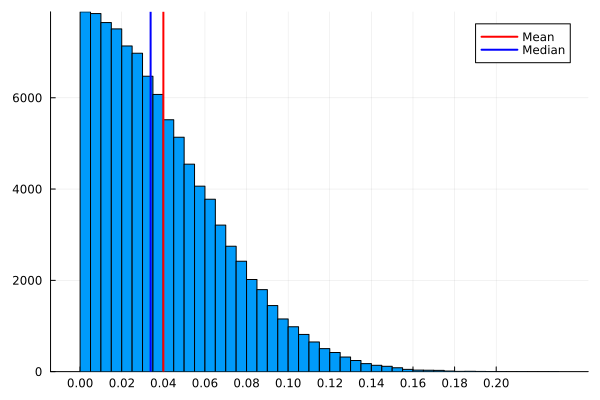

In [6]:

data = abs.(randn(100000) .* 0.05)

# Calculate mean and median
mean_val = mean(data)
median_val = median(data)
println("Mean: ", mean_val)
println("Median: ", median_val)

# # Estimate mode by finding the bin with the highest frequency
# counts, edges = histogram(data, bins=50, plot=false)
# bin_centers = (edges[1:end-1] + edges[2:end]) ./ 2
# mode_val = bin_centers[argmax(counts)]

# Plot histogram
histogram(data, bins = 50, xticks = -0.2:0.02:0.2, label = "", legend = :topright)

# Add lines for mean, median, and mode
vline!([mean_val], label = "Mean", lw=2, lc=:red)
vline!([median_val], label = "Median", lw=2, lc=:blue)
# vline!([mode_val], label = "Mode", lw=2, lc=:green)

In [7]:
# Load from file
all_outputs = open("xxy_T_phis_sigma=1.jls", "r") do io
    deserialize(io)
end

Dict{Tuple{Float64, Int64}, NamedTuple} with 81 entries:
  (0.25, 30)   => (time_points = 1:200, predicted = [-0.00232294, 0.0568937, 0.…
  (-0.99, 50)  => (time_points = 1:200, predicted = [-0.191431, 0.246991, -0.30…
  (0.75, 20)   => (time_points = 1:200, predicted = [0.0325851, 0.0819132, 0.06…
  (-0.75, 5)   => (time_points = 1:200, predicted = [-0.0811844, 0.118363, -0.0…
  (0.25, 3)    => (time_points = 1:200, predicted = [-0.00232294, 0.0568937, 0.…
  (0.99, 20)   => (time_points = 1:200, predicted = [0.284553, 0.339182, 0.3380…
  (0.0, 30)    => (time_points = 1:200, predicted = [-0.00862495, 0.0574744, -0…
  (-0.25, 75)  => (time_points = 1:200, predicted = [-0.0221, 0.0629994, -0.031…
  (0.0, 3)     => (time_points = 1:200, predicted = [-0.00862495, 0.0574744, 0.…
  (-0.99, 40)  => (time_points = 1:200, predicted = [-0.191431, 0.246991, -0.30…
  (-0.75, 100) => (time_points = 1:200, predicted = [-0.0811844, 0.118363, -0.0…
  (-0.25, 10)  => (time_points = 1:200, predicted = 

In [8]:
collect(keys(all_outputs))

81-element Vector{Tuple{Float64, Int64}}:
 (0.25, 30)
 (-0.99, 50)
 (0.75, 20)
 (-0.75, 5)
 (0.25, 3)
 (0.99, 20)
 (0.0, 30)
 (-0.25, 75)
 (0.0, 3)
 (-0.99, 40)
 ⋮
 (-0.75, 3)
 (-0.25, 100)
 (0.75, 30)
 (0.99, 30)
 (-0.99, 75)
 (0.75, 3)
 (-0.99, 10)
 (0.99, 3)
 (-0.75, 20)

In [9]:
# Create a new dictionary to store enhanced results
enhanced_outputs = Dict{Tuple{Float64,Int64},NamedTuple}()

for (key, output) in all_outputs
    # Extract all prediction vectors and actual values
    actual = output.actual
    preds = (
        predicted = output.predicted,
        mean_pred = output.mean_predictions,
        ar_pred = output.ar_predictions
    )
    
    # Calculate MAEs for each prediction type
    maes = (
        predicted_mae = mean(abs.(preds.predicted .- actual)),
        mean_pred_mae = mean(abs.(preds.mean_pred .- actual)),
        ar_pred_mae = mean(abs.(preds.ar_pred .- actual))
    )
    
    # Merge with existing metrics
    new_metrics = merge(output.metrics, maes)
    
    # Create new NamedTuple with all original fields plus new MAEs
    enhanced_outputs[key] = merge(
        output,
        (metrics = new_metrics,)
    )
end

In [10]:
phi_values = sort(unique(k[1] for k in keys(all_outputs)))
train_lengths = sort(unique(k[2] for k in keys(all_outputs)))
losses = sort(unique(v.metrics.model_mae for v in values(all_outputs)))

81-element Vector{Float64}:
 0.044092953123435974
 0.044772239922516596
 0.04501670695121651
 0.046322047246571615
 0.04666929238298334
 0.04741719536617049
 0.047614508333289396
 0.0476262790586623
 0.048733810488249096
 0.04933878329424028
 ⋮
 0.21249543192800954
 0.2518720056462023
 0.2567814119092568
 0.2574058075265253
 0.25805753688906397
 0.28846317196050786
 0.31945876900174963
 0.32475405262360496
 0.3267443240857121

In [11]:
phi_values = sort(unique(k[1] for k in keys(enhanced_outputs)))
train_lengths = sort(unique(k[2] for k in keys(enhanced_outputs)))
loss_matrix_model = zeros(length(train_lengths), length(phi_values))

for (i, len) in enumerate(train_lengths), (j, phi) in enumerate(phi_values)
    if haskey(enhanced_outputs, (phi, len))
        loss_matrix_model[i, j] = enhanced_outputs[(phi, len)].metrics.predicted_mae
    else
        loss_matrix_model[i, j] = NaN  # Missing data
    end
end

loss_matrix_mean = zeros(length(train_lengths), length(phi_values))

for (i, len) in enumerate(train_lengths), (j, phi) in enumerate(phi_values)
    if haskey(enhanced_outputs, (phi, len))
        loss_matrix_mean[i, j] = enhanced_outputs[(phi, len)].metrics.mean_pred_mae
    else
        loss_matrix_mean[i, j] = NaN  # Missing data
    end
end

loss_matrix_ar = zeros(length(train_lengths), length(phi_values))

for (i, len) in enumerate(train_lengths), (j, phi) in enumerate(phi_values)
    if haskey(enhanced_outputs, (phi, len))
        loss_matrix_ar[i, j] = enhanced_outputs[(phi, len)].metrics.ar_pred_mae
    else
        loss_matrix_ar[i, j] = NaN  # Missing data
    end
end

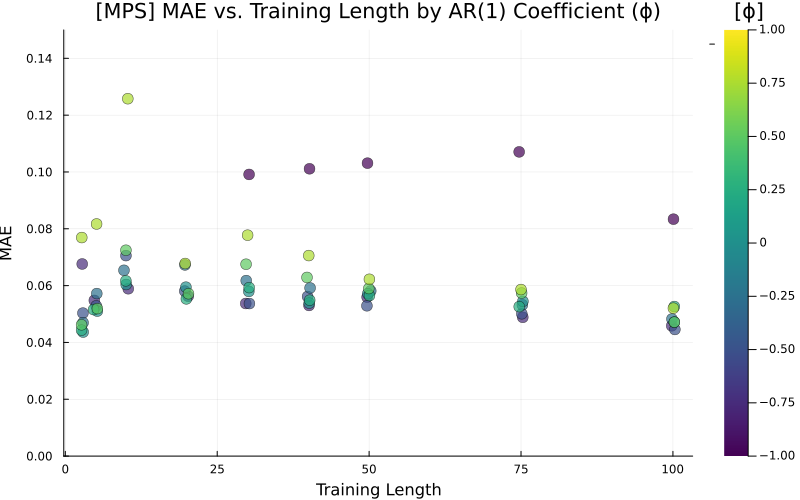

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [16]:
gr()

# Set layout: main plot and dummy heatmap for colorbar
layout = @layout [a{0.95w} b]
cmap = cgrad(:viridis)

# Create the main scatter plot
plt = plot(
    xlabel = "Training Length",
    ylabel = "MAE",
    legend = false,
    size = (800, 500),
    # yscale = :log10
    ylim = (0,0.15),
    yticks = 0:0.02:0.15
)

# Get sorted unique phi values
phi_values = sort(unique([k[1] for k in keys(enhanced_outputs)]))
num_phis = length(phi_values)

# Convert color scheme to palette
color_palette = cmap[1:num_phis]

# Jitter
train_lengths_all = [k[2] for k in keys(enhanced_outputs)]
jitter_strength = 0.25 * minimum(train_lengths_all)

# Plot each phi
for (i, phi) in enumerate(phi_values)
    filtered_entries = [(k[2], v.metrics.predicted_mae) for (k, v) in enhanced_outputs if k[1] ≈ phi]
    train_lengths = [x[1] for x in filtered_entries]
    losses = [x[2] for x in filtered_entries]

    sort_order = sortperm(train_lengths)
    train_lengths = train_lengths[sort_order]
    losses = losses[sort_order]

    jittered_lengths = train_lengths .+ jitter_strength .* (rand(length(train_lengths)) .- 0.5)
    color_value = (phi - minimum(phi_values)) / (maximum(phi_values) - minimum(phi_values))

    scatter!(
        plt,
        jittered_lengths,
        losses,
        color = cmap[color_value],
        markersize = 6,
        alpha = 0.7,
        markerstrokewidth = 0.5,
        label = "",
        title = "[MPS] MAE vs. Training Length by AR(1) Coefficient (ϕ)"
    )

    # filtered_entries = [(k[2], v.metrics.mean_pred_mae) for (k, v) in enhanced_outputs if k[1] ≈ phi]
    # train_lengths = [x[1] for x in filtered_entries]
    # losses = [x[2] for x in filtered_entries]

    # scatter!(
    #     plt,
    #     jittered_lengths,
    #     losses,
    #     color = cmap[color_value],
    #     markersize = 6,
    #     alpha = 0.7,
    #     markerstrokewidth = 0.5,
    #     label = "",
    #     title = "[Mean] MAE vs. Training Length by AR(1) Coefficient (ϕ)"
    # )

    # filtered_entries = [(k[2], v.metrics.ar_pred_mae) for (k, v) in enhanced_outputs if k[1] ≈ phi]
    # train_lengths = [x[1] for x in filtered_entries]
    # losses = [x[2] for x in filtered_entries]

    # scatter!(
    #     plt,
    #     jittered_lengths,
    #     losses,
    #     color = cmap[color_value],
    #     markersize = 6,
    #     alpha = 0.7,
    #     markerstrokewidth = 0.5,
    #     label = "",
    #     title = "[AR] MAE vs. Training Length by AR(1) Coefficient (ϕ)"
    # )
end

# Dummy heatmap for colorbar
dummy_heatmap = heatmap(
    [0 0; 1 1],  # dummy 2x2 data
    clims = (-1, 1),
    framestyle = :none,
    c = cmap,
    lims = (-1, 0),
    title = "     [ϕ]"
)

# Combine plots with layout
final_plot = plot(plt, dummy_heatmap, layout = layout)

display(final_plot)

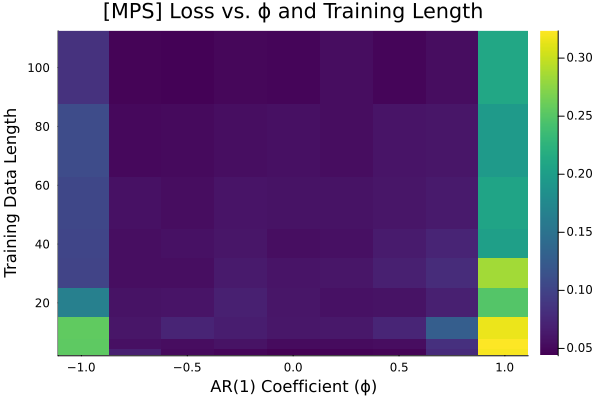

In [117]:
heatmap(phi_values, train_lengths, loss_matrix_model,
        xlabel = "AR(1) Coefficient (ϕ)",
        ylabel = "Training Data Length",
        title = "[MPS] Loss vs. ϕ and Training Length",
        color = :viridis)  # Use a perceptually uniform colormap

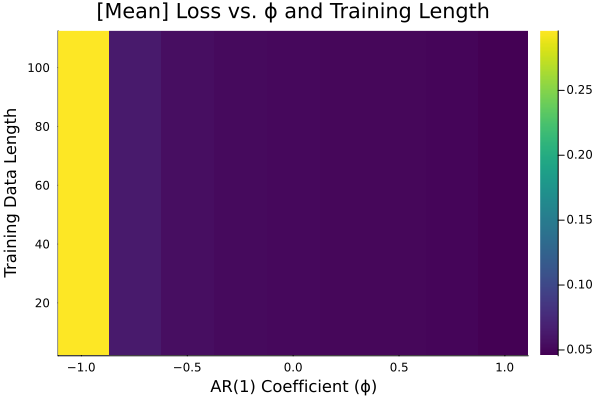

In [118]:
heatmap(phi_values, train_lengths, loss_matrix_mean,
        xlabel = "AR(1) Coefficient (ϕ)",
        ylabel = "Training Data Length",
        title = "[Mean] Loss vs. ϕ and Training Length",
        color = :viridis)  # Use a perceptually uniform colormap

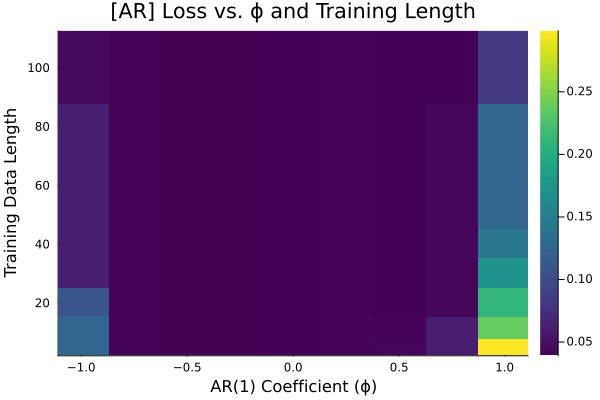

In [120]:
heatmap(phi_values, train_lengths, loss_matrix_ar,
        xlabel = "AR(1) Coefficient (ϕ)",
        ylabel = "Training Data Length",
        title = "[AR] Loss vs. ϕ and Training Length",
        color = :viridis)  # Use a perceptually uniform colormap